# Imports

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 37.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.2/224.2 kB 6.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
import sys
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch
import torch.nn.functional as F
import torchtext

import seaborn as sns
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import time

from transformers import DistilBertTokenizer, AutoModelForSequenceClassification

cuda


# Mount Drive and set up directories

In [ ]:
# Mount drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
# Copy dataset locally
!cp 'drive/MyDrive/CSCE-5290-project/indeed_dataset.csv' 'indeed_dataset.csv'

In [ ]:
# Set up directories
path_to_project = 'drive/MyDrive/CSCE-5290-project'
path_to_results = os.path.join(path_to_project,'Results', 'Transfer_Learning')
path_to_raw_dataset = 'indeed_dataset.csv'

In [ ]:
path_to_results

'drive/MyDrive/CSCE-5290-project/Results/Transfer_Learning'

# Load in the dataset and prepare the data

In [ ]:
# Load in the data
raw_df = pd.read_csv(path_to_raw_dataset)

# Drop columns not used for the model
raw_df = raw_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'job_link'])
raw_df = raw_df.reset_index(drop=True)
raw_df = raw_df.dropna().drop_duplicates()
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14677 entries, 0 to 14813
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   job_id           14677 non-null  object
 1   job_title        14677 non-null  object
 2   location         14677 non-null  object
 3   experience       14677 non-null  object
 4   education        14677 non-null  object
 5   job_type         14677 non-null  object
 6   job_description  14677 non-null  object
dtypes: object(7)
memory usage: 917.3+ KB


In [ ]:
# Take a look at the distribution of the data
for column in [x for x in raw_df.columns if x not in ['job_description']]:
  print(column)
  print(raw_df[column].value_counts())
  print()

job_id
2234aeb26fb8dcd1    15
561aa9e43fe57eaf    13
fa7a2a95e7d5ea3d    13
954176f960389df0    11
8fc75611d10238db    11
                    ..
edc4f5031bdfc20b     1
f22195f9c66bdd19     1
8fd27a178ad62377     1
4d23759984df3db5     1
819d606fb220e500     1
Name: job_id, Length: 7807, dtype: int64

job_title
Software Engineer            3587
Cloud Engineer               2913
Data Analyst                 1946
Data Architect               1496
Business Analyst             1327
Machine Learning Engineer    1028
Data Scientist                886
QA Engineer                   625
Data Engineer                 443
DevOps Engineer               318
QA Analyst                    108
Name: job_title, dtype: int64

location
Dallas, TX           3103
San Francisco, CA    2890
Chicago, IL          2014
Austin, TX           1870
Los Angeles, CA      1766
Seattle, WA          1652
San Diego, CA        1382
Name: location, dtype: int64

experience
MID_LEVEL       7610
SENIOR_LEVEL    5261
ENTRY_LEV

# Creating a Pytorch Dataset and Dataloader

In [ ]:
#########################################################################################################################################
FEATURE_COLUMN = 'job_description'
LABEL_COLUMN = 'experience'
#########################################################################################################################################

In [ ]:
# Creating features column
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenized_df = raw_df.copy()
tokenized_df['features'] = raw_df[FEATURE_COLUMN].map(lambda x: tokenizer(x))

Token indices sequence length is longer than the specified maximum sequence length for this model (727 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
tokenized_df[['job_description', 'features']]

,job_description,features
0,"LIS Business Analyst (Austin, Texas) - job pos...","[input_ids, attention_mask]"
1,Systems Operations Analyst - job post CEVA Log...,"[input_ids, attention_mask]"
2,Business Intelligence Analyst - job post Hire ...,"[input_ids, attention_mask]"
3,Business Analyst I - job post Silicon Labs Car...,"[input_ids, attention_mask]"
4,Business Intelligence Analyst - job post ABRAC...,"[input_ids, attention_mask]"
...,...,...
14809,Sr. Full Stack Engineer - Remote - job post Sy...,"[input_ids, attention_mask]"
14810,Oracle EBS Developer - Solution Manager - Loca...,"[input_ids, attention_mask]"
14811,API Management Engineer - Senior Consultant (R...,"[input_ids, attention_mask]"
14812,Sr. Ruby on Rails Developer - job post Medical...,"[input_ids, attention_mask]"


In [ ]:
# df_grouped[LABEL_COLUMN] = df_grouped[LABEL_COLUMN].apply(lambda x: tuple(x)).astype('category')
# tokenized_df[LABEL_COLUMN] = pd.Categorical(raw_df[LABEL_COLUMN], categories=['BACHELORS_DEGREE', 'MASTERS_DEGREE', 'DOCTORAL_DEGREE'])
# tokenized_df[LABEL_COLUMN] = pd.Categorical(raw_df[LABEL_COLUMN], categories=['INTERNSHIP', 'TEMPORARY','CONTRACT', 'PARTTIME', 'FULLTIME'])
tokenized_df[LABEL_COLUMN] = pd.Categorical(raw_df[LABEL_COLUMN])
tokenized_df['label'] = tokenized_df[LABEL_COLUMN].cat.codes
tokenized_df

,job_id,job_title,location,experience,education,job_type,job_description,features,label
0,d3fe7488bead34f4,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,"LIS Business Analyst (Austin, Texas) - job pos...","[input_ids, attention_mask]",0
1,0c788d52c2a5420e,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Systems Operations Analyst - job post CEVA Log...,"[input_ids, attention_mask]",0
2,ee82dee9280384d9,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Business Intelligence Analyst - job post Hire ...,"[input_ids, attention_mask]",0
3,8df855078f305a53,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Business Analyst I - job post Silicon Labs Car...,"[input_ids, attention_mask]",0
4,5a563d5d009c2306,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Business Intelligence Analyst - job post ABRAC...,"[input_ids, attention_mask]",0
...,...,...,...,...,...,...,...,...,...
14809,3ff0ac9115f15124,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,Sr. Full Stack Engineer - Remote - job post Sy...,"[input_ids, attention_mask]",2
14810,3e7a3c512c32b1e1,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,Oracle EBS Developer - Solution Manager - Loca...,"[input_ids, attention_mask]",2
14811,4caed4fe745916a8,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,API Management Engineer - Senior Consultant (R...,"[input_ids, attention_mask]",2
14812,082f08b79773672f,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,Sr. Ruby on Rails Developer - job post Medical...,"[input_ids, attention_mask]",2


In [ ]:
# raw_df[[FEATURE_COLUMN, LABEL_COLUMN, 'features', 'label']]
# grouped_df = tokenized_df.groupby(['job_id', 'job_title']).agg({'label': 'max', 'features': 'first'}).reset_index()
grouped_df = tokenized_df.copy()

In [ ]:
grouped_df

,job_id,job_title,location,experience,education,job_type,job_description,features,label
0,d3fe7488bead34f4,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,"LIS Business Analyst (Austin, Texas) - job pos...","[input_ids, attention_mask]",0
1,0c788d52c2a5420e,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Systems Operations Analyst - job post CEVA Log...,"[input_ids, attention_mask]",0
2,ee82dee9280384d9,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Business Intelligence Analyst - job post Hire ...,"[input_ids, attention_mask]",0
3,8df855078f305a53,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Business Analyst I - job post Silicon Labs Car...,"[input_ids, attention_mask]",0
4,5a563d5d009c2306,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Business Intelligence Analyst - job post ABRAC...,"[input_ids, attention_mask]",0
...,...,...,...,...,...,...,...,...,...
14809,3ff0ac9115f15124,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,Sr. Full Stack Engineer - Remote - job post Sy...,"[input_ids, attention_mask]",2
14810,3e7a3c512c32b1e1,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,Oracle EBS Developer - Solution Manager - Loca...,"[input_ids, attention_mask]",2
14811,4caed4fe745916a8,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,API Management Engineer - Senior Consultant (R...,"[input_ids, attention_mask]",2
14812,082f08b79773672f,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,Sr. Ruby on Rails Developer - job post Medical...,"[input_ids, attention_mask]",2


In [ ]:
grouped_df['label'].value_counts()

1    7610
2    5261
0    1806
Name: label, dtype: int64

In [ ]:
# grouped_df['lengths'] = [len(grouped_df['features'][i]['input_ids']) for i in range(len(grouped_df))]
# grouped_df['lengths'].hist()
# plt.title('Token Length Histogram')
# plt.xlabel('Token Length')
# plt.ylabel('Count')

In [ ]:
#########################################################################################################################################
# Setting max tokens according to the distribution trying to preserve memory
MAX_TOKENS = 1
#########################################################################################################################################

In [ ]:
class IndeedDataset(Dataset):
  ''' Indeed Jobs Dataset '''

  def __init__(self, pandas_dataframe, max_tokens):
    self.dataframe = pandas_dataframe
    self.max_tokens = max_tokens
  
  def __len__(self):
    return len(self.dataframe)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
            idx = idx.tolist()
    features = self.dataframe['features'].iloc[idx]
    features['input_ids'] = F.pad(torch.tensor(features['input_ids']), (1,self.max_tokens-len(features)), 'constant', 0)[:self.max_tokens]
    features['attention_mask'] = F.pad(torch.tensor(features['attention_mask']), (1,self.max_tokens-len(features)), 'constant', 0)[:self.max_tokens]
    # features['token_type_ids'] = F.pad(torch.tensor(features['token_type_ids']), (1,self.max_tokens-len(features)), 'constant', 0)[:self.max_tokens]
    label = torch.tensor(self.dataframe['label'].iloc[idx], dtype=torch.long)
    return features, label
  
  def label(self):
    return self.dataframe[['label']]

In [ ]:
path_to_processed_data = os.path.join(path_to_results, f'{LABEL_COLUMN}_processed_data.pkl')

In [ ]:
grouped_df.to_pickle(path_to_processed_data)

In [ ]:
grouped_df = pd.read_pickle(path_to_processed_data)

In [ ]:
grouped_df

,job_id,job_title,location,experience,education,job_type,job_description,features,label
0,d3fe7488bead34f4,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,"LIS Business Analyst (Austin, Texas) - job pos...","[input_ids, attention_mask]",0
1,0c788d52c2a5420e,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Systems Operations Analyst - job post CEVA Log...,"[input_ids, attention_mask]",0
2,ee82dee9280384d9,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Business Intelligence Analyst - job post Hire ...,"[input_ids, attention_mask]",0
3,8df855078f305a53,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Business Analyst I - job post Silicon Labs Car...,"[input_ids, attention_mask]",0
4,5a563d5d009c2306,Business Analyst,"Austin, TX",ENTRY_LEVEL,BACHELORS_DEGREE,FULLTIME,Business Intelligence Analyst - job post ABRAC...,"[input_ids, attention_mask]",0
...,...,...,...,...,...,...,...,...,...
14809,3ff0ac9115f15124,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,Sr. Full Stack Engineer - Remote - job post Sy...,"[input_ids, attention_mask]",2
14810,3e7a3c512c32b1e1,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,Oracle EBS Developer - Solution Manager - Loca...,"[input_ids, attention_mask]",2
14811,4caed4fe745916a8,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,API Management Engineer - Senior Consultant (R...,"[input_ids, attention_mask]",2
14812,082f08b79773672f,Software Engineer,"Seattle, WA",SENIOR_LEVEL,MASTERS_DEGREE,FULLTIME,Sr. Ruby on Rails Developer - job post Medical...,"[input_ids, attention_mask]",2


In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

X = grouped_df # Contains all columns.
y = grouped_df[['label']] # Dataframe of just the column on which to stratify.

# Stratified Sampling for train and val
df_train, df_temp, y_train, y_temp = train_test_split(X,
                                                      y,
                                                      stratify=y,
                                                      test_size=0.2,
                                                      random_state=999)

# Split the temp dataframe into val and test dataframes.
df_val, df_test, y_val, y_test = train_test_split(df_temp,
                                                  y_temp,
                                                  stratify=y_temp,
                                                  test_size=0.5,
                                                  random_state=999)

In [ ]:
training_data = IndeedDataset(df_train, MAX_TOKENS)
validation_data = IndeedDataset(df_val, MAX_TOKENS)
test_data = IndeedDataset(df_test, MAX_TOKENS)

In [ ]:
torch.set_printoptions(precision=8)

In [ ]:
class_sample_counts = [len([i for i in training_data if i[1]==t]) for t in range(len(grouped_df['label'].unique()))]
weight = 1. / np.array(class_sample_counts)
samples_weight = np.array([weight[t[1]] for t in training_data], dtype=np.double)
samples_weight = torch.from_numpy(samples_weight)

sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

<ipython-input-41-f27c745d4934>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features['input_ids'] = F.pad(torch.tensor(features['input_ids']), (1,self.max_tokens-len(features)), 'constant', 0)[:self.max_tokens]
<ipython-input-41-f27c745d4934>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features['attention_mask'] = F.pad(torch.tensor(features['attention_mask']), (1,self.max_tokens-len(features)), 'constant', 0)[:self.max_tokens]


In [ ]:
BATCH_SIZE = 1
# Creating the Data Loaders
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, sampler=sampler)
# train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
sample = next(iter(train_dataloader))
sample

<ipython-input-56-f27c745d4934>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features['input_ids'] = F.pad(torch.tensor(features['input_ids']), (1,self.max_tokens-len(features)), 'constant', 0)[:self.max_tokens]
<ipython-input-56-f27c745d4934>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features['attention_mask'] = F.pad(torch.tensor(features['attention_mask']), (1,self.max_tokens-len(features)), 'constant', 0)[:self.max_tokens]


[{'input_ids': tensor([[0]]), 'attention_mask': tensor([[0]])}, tensor([2])]

# Model definition

In [3]:
# num_labels = len(grouped_df['label'].unique())
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

In [4]:
print("DistilBert Number of Parameters:",sum(p.numel() for p in model.parameters()))

DistilBert Number of Parameters: 66958086


In [5]:
print(model)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
from torch.optim import AdamW
from transformers import get_scheduler
import torch

num_epochs = 3
optimizer = AdamW(model.parameters(), lr=1e-5)

num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
def evaluate(model: nn.Module, eval_data) -> float:
  criterion = nn.CrossEntropyLoss()
  model.eval()  # turn on evaluation mode
  total_loss = 0.
  with torch.no_grad():
    for (features, labels) in eval_data:
      features = features.to(device)
      labels = labels.to(device)
      output = model(**features, labels=labels)
      total_loss += output.loss.item()
      # print(labels)
      # print(output)
  return total_loss / (len(eval_data) - 1)

In [ ]:
model.to(device)
val_loss = evaluate(model, validation_dataloader)
val_loss

1.1439064608679876

In [ ]:
history = {"loss": [], "val_loss": []}

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))
model.train()
best = val_loss
for epoch in range(num_epochs):
  tot_loss = 0
  for i, (features, labels) in enumerate(train_dataloader):
    features = features.to(device)
    labels = labels.to(device)
    outputs = model(**features, labels=labels)
    loss = outputs.loss
    with torch.no_grad():
      tot_loss += loss.item()
    loss.backward()
    optimizer.step()
    lr_scheduler.step()
    optimizer.zero_grad()
    progress_bar.update(1)
  curr_loss = tot_loss/len(train_dataloader)
  val_loss = evaluate(model, validation_dataloader)
  if (val_loss < best):
    best_model_params_path = os.path.join(path_to_project,'models', f"{LABEL_COLUMN}_best_tl.pt")
    torch.save(model.state_dict(), best_model_params_path)
  print(f"epoch: {epoch} | loss: {curr_loss} | val_loss: {val_loss}")
  history['loss'].append(curr_loss)
  history['val_loss'].append(val_loss)

  0%|          | 0/441 [00:00<?, ?it/s]

<ipython-input-18-f27c745d4934>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features['input_ids'] = F.pad(torch.tensor(features['input_ids']), (1,self.max_tokens-len(features)), 'constant', 0)[:self.max_tokens]
<ipython-input-18-f27c745d4934>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features['attention_mask'] = F.pad(torch.tensor(features['attention_mask']), (1,self.max_tokens-len(features)), 'constant', 0)[:self.max_tokens]


OutOfMemoryError: ignored

In [ ]:
# torch.cuda.empty_cache()

In [ ]:
history_df = pd.DataFrame(history)
history_df.plot()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title(f'Loss vs. Epoch for "{LABEL_COLUMN}" column, Transfer Learning')
plt.savefig(f'{path_to_results}/trainig_{LABEL_COLUMN}_Transfer_Learning_Transformer.png')
plt.show()

In [ ]:
best_model_params_path = os.path.join(path_to_project,'models', f"{LABEL_COLUMN}_best_tl.pt")
model.load_state_dict(torch.load(best_model_params_path))
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Set the model to evaluation mode
model.eval()

# Initialize variables for storing predictions and labels
all_preds = []
all_labels = []

# Iterate over batches in the test data loader
for features, labels in test_dataloader:
    # Get the input features and labels
    features = features.to(device)
    labels = labels.to(device)
    # print(features, labels)

    # Make predictions
    with torch.no_grad():
        preds = model(**features, labels=labels)
        # print('raw', preds)
        preds = F.softmax(preds.logits, dim=1)
        preds = torch.argmax(preds, dim=1)
        # print('argmax', preds)
        # print('labels', labels)
    # break
    # Append predictions and labels to the lists
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

<ipython-input-56-f27c745d4934>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features['input_ids'] = F.pad(torch.tensor(features['input_ids']), (1,self.max_tokens-len(features)), 'constant', 0)[:self.max_tokens]
<ipython-input-56-f27c745d4934>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features['attention_mask'] = F.pad(torch.tensor(features['attention_mask']), (1,self.max_tokens-len(features)), 'constant', 0)[:self.max_tokens]


In [ ]:
cm = np.array([[426, 0, 247],[42,0, 34], [446,0,273]])
cm
LABEL_COLUMN = "education"

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report for "education" column, Transfer Learning:
              precision    recall  f1-score   support

           0       0.12      1.00      0.22       181
           1       0.00      0.00      0.00       761
           2       0.00      0.00      0.00       526

    accuracy                           0.12      1468
   macro avg       0.04      0.33      0.07      1468
weighted avg       0.02      0.12      0.03      1468

Confusion Matrix:


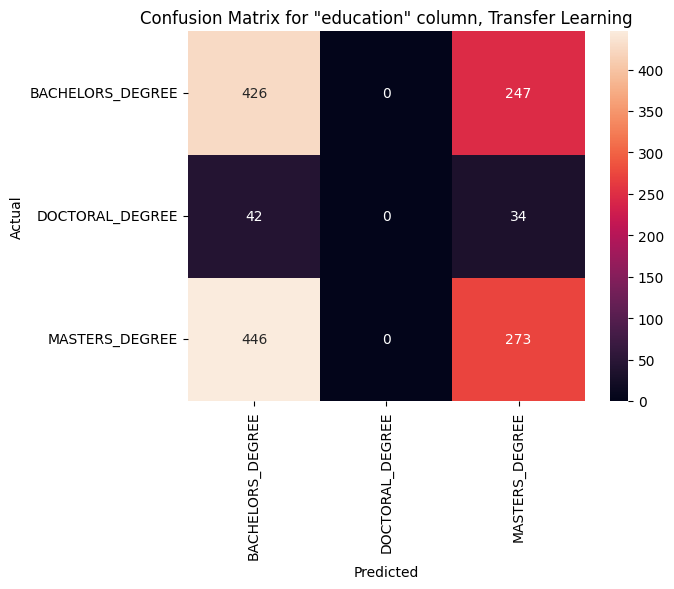

In [ ]:
# Get the confusion matrix and classification report
# cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds) #, labels=list(tokenized_df[LABEL_COLUMN].cat.categories))

# Print the confusion matrix and classification report
print(f'Classification Report for "{LABEL_COLUMN}" column, Transfer Learning:')
print(report)
print("Confusion Matrix:")
# print(cm)
sns.heatmap(cm, annot=True, fmt='1',\
            yticklabels=list(grouped_df[LABEL_COLUMN].cat.categories),\
            xticklabels=list(grouped_df[LABEL_COLUMN].cat.categories))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for "{LABEL_COLUMN}" column, Transfer Learning')
plt.savefig(f'{path_to_results}/confusion_{LABEL_COLUMN}_Transfer_Learning.png')
plt.show()